In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

In [2]:
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

In [3]:
def preprocess_helper(df):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    #just area
    df = df[(df['area'] > 200) & (df['aspect_ratio'] > 1.9) & (df['area'] < 12000)]
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
    
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    thresh = 10

    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > thresh:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)

    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [4]:
def plot_components(df,img,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [5]:
def plot_nn_patch(df,img,root_label, neighbor_labels):          
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [6]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
     
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k]
    res_df = res_df.sort_values(by=['theta'])
    
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df

In [7]:
def build_context_layout(img):
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    print("total no of words(>3 chars) identified:",df.shape[0])
    
    context_vectors = []
    k_neigh = 5
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
        except Exception as e:
            print()
            
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4)
    context_vectors = context_vectors.round(4)
    print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors

In [8]:
def feature_distance(a,b):
    m,n = a.shape[0],b.shape[0]
    if(m > n):
        c = b
        b = a
        a = c
        m,n = a.shape[0],b.shape[0]
    distances = np.zeros(m)
    for i in range(m):
        dist = np.linalg.norm(b - a[i, np.newaxis, :, :], axis=(1, 2))
        closest_index = np.argmin(dist)
        distances[i] = dist[closest_index]
    distances = np.round(distances,2)
    total_distance = np.round(np.sum(distances),2)
    return distances,total_distance

In [9]:
def count_matches(query_vectors,doc_vectors):
    matches = np.all(query_vectors[:, np.newaxis] == doc_vectors, axis=(2, 3))
    num_matches = np.sum(matches, axis=1)
    num_matches = len(num_matches[num_matches == 1])
    return num_matches, 100*num_matches/len(query_vectors)

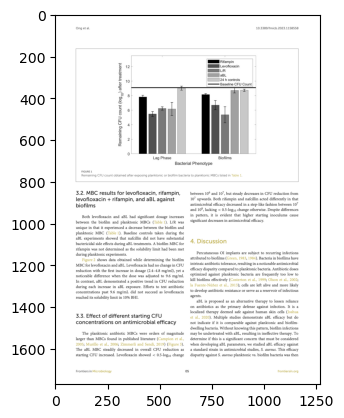

In [10]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

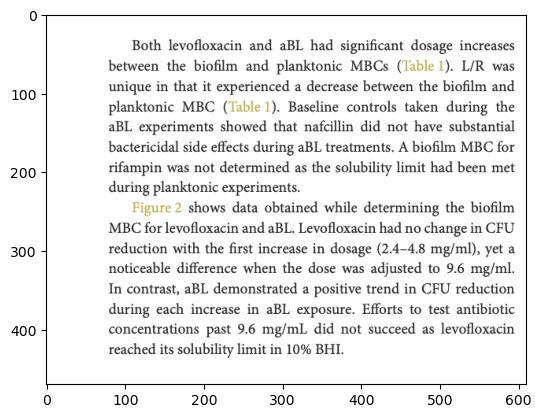

In [11]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

In [12]:
query_vectors = build_context_layout(img)
len(query_vectors)

total no of words(>3 chars) identified: 85
total no of contexts extracted: 85


85

In [14]:
doc_vectors = build_context_layout(img_full)
len(doc_vectors)

total no of words(>3 chars) identified: 291
total no of contexts extracted: 283


283

In [15]:
feature_distance(query_vectors,doc_vectors)

(array([0.  , 0.  , 0.  , 0.  , 3.06, 0.  , 0.  , 0.  , 0.  , 0.  , 5.12,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 4.64, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 5.93, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.  , 0.  , 0.  , 0.  ,
        0.  , 2.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.57, 0.  , 0.  ,
        0.  , 0.  , 3.16, 0.  , 0.  , 0.  , 0.  , 0.  ]),
 27.57)

In [17]:
feature_distance(query_vectors,doc_vectors)

(array([13.43,  7.82,  5.51,  8.29,  8.22,  8.35,  6.89,  5.24,  7.98,
         6.38, 11.09,  7.07,  6.88,  6.71,  6.95,  9.57,  7.22,  5.64,
         6.04,  5.32,  5.55,  6.95,  6.57,  5.85,  5.85,  7.63,  7.29,
         6.54,  6.88,  8.11,  5.62,  6.76,  8.29,  7.24,  5.85,  5.06,
         6.83,  4.92,  9.86,  7.38,  6.4 ,  7.6 ,  6.23,  7.  ,  3.38,
        10.12,  6.16, 12.87,  9.29,  6.7 ,  6.68,  7.94, 10.43,  8.09,
         6.17,  7.77,  9.13,  7.14,  6.94,  5.51,  6.05,  7.45,  8.07,
         7.81,  4.08,  5.69,  6.91,  7.64,  6.71,  6.78,  6.27,  7.27,
         5.47,  6.49,  6.92,  5.91,  7.29,  8.17,  5.48,  6.62,  7.13,
        11.17,  5.16,  8.21,  7.09]),
 609.02)

In [21]:
count_matches(query_vectors,doc_vectors)

(77, 90.58823529411765)

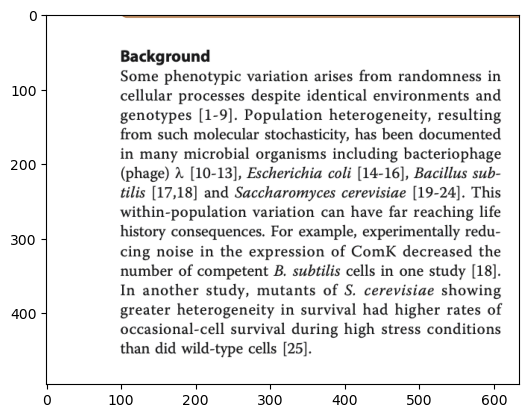

In [16]:
other_img = cv2.imread('./../../samples/imgPatch.png')
plt.imshow(other_img)

In [18]:
other_query_vectors = build_context_layout(other_img)
len(other_query_vectors)

total no of words(>3 chars) identified: 71
total no of contexts extracted: 69


69

In [19]:
feature_distance(other_query_vectors,doc_vectors)

(array([5.15, 1.02, 1.75, 2.67, 2.77, 1.39, 1.93, 1.74, 0.96, 1.04, 2.04,
        1.4 , 1.76, 1.18, 1.81, 1.91, 1.53, 1.26, 1.19, 4.77, 2.64, 1.53,
        2.26, 1.93, 2.18, 3.35, 2.5 , 1.08, 2.1 , 1.54, 1.31, 2.69, 1.28,
        2.04, 2.27, 1.34, 2.15, 2.95, 3.38, 1.33, 0.44, 3.15, 1.22, 1.18,
        2.44, 1.22, 1.55, 2.26, 1.44, 2.41, 3.02, 1.09, 2.06, 1.86, 1.53,
        1.47, 1.35, 2.25, 1.65, 1.38, 3.63, 2.27, 2.1 , 2.39, 1.82, 1.89,
        8.4 , 2.52, 5.23]),
 146.34)

In [20]:
count_matches(other_query_vectors,doc_vectors)

(0, 0.0)

In [22]:
img.shape

(470, 610, 3)

In [23]:
asp_ratio = img.shape[1] / img.shape[0] 
asp_ratio

1.297872340425532

In [24]:
940 * asp_ratio

1220.0

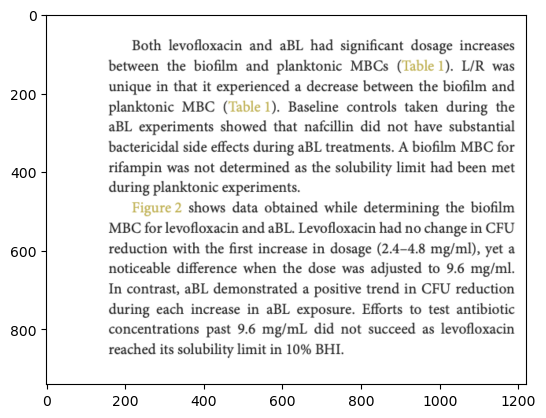

In [25]:
dimension = (1220,940)
img2 = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
plt.imshow(img2)

In [26]:
query2_vectors = build_context_layout(img2)
len(query2_vectors)

total no of words(>3 chars) identified: 105
total no of contexts extracted: 105


105

In [27]:
feature_distance(query2_vectors,doc_vectors)

(array([3.28, 1.29, 1.01, 0.28, 3.21, 3.11, 1.41, 1.52, 0.93, 0.29, 0.4 ,
        6.09, 2.33, 0.99, 0.41, 0.48, 0.45, 1.73, 1.02, 1.57, 1.4 , 1.13,
        1.1 , 1.31, 1.01, 0.82, 1.36, 1.12, 1.34, 1.31, 4.18, 0.99, 2.97,
        1.26, 2.19, 1.34, 1.11, 1.31, 0.31, 2.34, 2.13, 1.35, 1.24, 2.08,
        2.19, 0.59, 2.34, 5.78, 2.16, 1.88, 1.23, 0.83, 1.5 , 2.22, 1.26,
        1.85, 1.8 , 3.18, 1.36, 2.31, 1.02, 1.41, 1.43, 3.9 , 2.57, 4.51,
        1.41, 1.87, 2.14, 1.36, 1.19, 1.41, 1.02, 0.48, 0.91, 1.  , 0.48,
        1.5 , 2.03, 0.81, 2.37, 0.44, 2.5 , 1.23, 0.52, 0.29, 0.46, 0.3 ,
        0.46, 1.32, 2.12, 1.46, 2.93, 2.34, 0.82, 1.34, 1.49, 1.11, 0.65,
        3.12, 1.67, 1.8 , 3.83, 2.88, 2.99]),
 173.87)

In [28]:
feature_distance(query_vectors,query2_vectors)

(array([3.28, 1.55, 3.19, 0.28, 0.4 , 1.77, 2.14, 1.48, 0.4 , 0.29, 1.13,
        1.36, 0.41, 0.48, 0.45, 3.83, 1.41, 1.96, 1.41, 1.11, 1.54, 1.75,
        1.36, 1.09, 1.  , 1.72, 1.32, 0.82, 1.41, 1.97, 1.41, 1.12, 0.31,
        0.96, 1.5 , 2.18, 3.24, 0.59, 6.31, 3.3 , 1.25, 1.5 , 2.24, 4.52,
        3.08, 4.66, 3.34, 7.44, 2.87, 2.54, 0.98, 2.68, 4.23, 1.22, 2.53,
        3.31, 2.14, 0.48, 1.07, 1.87, 0.48, 1.19, 0.34, 0.81, 2.77, 0.44,
        2.25, 2.08, 0.52, 0.29, 0.46, 0.3 , 0.46, 1.65, 1.83, 2.76, 1.54,
        2.39, 2.17, 3.01, 0.65, 1.67, 1.93, 5.32, 4.79]),
 159.28)

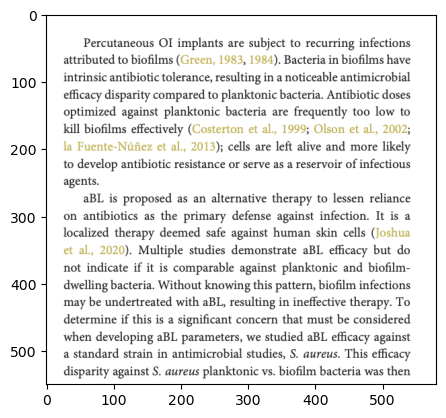

In [29]:
img21 = img_full[1100:1650, 620:1200]
plt.imshow(img21)

In [30]:
query21_vectors = build_context_layout(img21)
len(query21_vectors)

total no of words(>3 chars) identified: 105
total no of contexts extracted: 105


105

In [ ]:
feature_distance(query21_vectors,doc_vectors)

In [31]:
feature_distance(query21_vectors,query_vectors)

(array([8.88, 1.69, 0.97, 1.35, 3.06, 1.88, 2.31, 1.51, 1.8 , 1.5 , 5.12,
        1.51, 1.2 , 1.1 , 1.48, 3.01, 2.16, 1.44, 1.52, 1.18, 1.03, 2.23,
        2.24, 1.16, 1.42, 1.66, 0.78, 1.36, 1.62, 2.19, 2.3 , 0.77, 1.33,
        2.28, 1.4 , 1.47, 3.02, 3.97, 6.93, 3.6 , 1.7 , 1.94, 2.6 , 3.94,
        2.54, 5.06, 2.12, 6.48, 3.58, 2.27, 1.25, 3.02, 4.26, 1.  , 1.21,
        3.1 , 1.37, 1.19, 1.25, 1.92, 2.08, 1.12, 2.  , 1.71, 1.87, 1.38,
        2.69, 2.09, 1.74, 1.67, 0.9 , 2.4 , 1.42, 2.04, 1.57, 2.88, 1.32,
        2.21, 2.21, 3.17, 1.02, 5.22, 1.1 , 6.59, 6.56]),
 198.19)

In [32]:
feature_distance(query21_vectors,query2_vectors)

(array([3.13, 2.28, 4.21, 3.65, 2.58, 2.72, 3.74, 2.02, 4.91, 6.97, 2.6 ,
        6.67, 2.33, 2.37, 3.86, 3.67, 2.64, 4.08, 1.51, 3.69, 3.21, 1.92,
        1.14, 1.29, 1.37, 1.56, 3.11, 1.14, 1.35, 2.11, 1.63, 2.9 , 3.63,
        2.16, 2.35, 1.49, 1.11, 2.92, 2.24, 3.76, 4.12, 2.57, 1.23, 1.29,
        3.41, 3.73, 2.11, 1.21, 2.08, 1.52, 1.37, 2.12, 1.33, 1.19, 1.4 ,
        3.11, 3.29, 1.96, 2.22, 1.51, 1.34, 0.91, 2.07, 2.41, 2.26, 1.46,
        2.03, 2.08, 1.72, 2.54, 1.36, 1.91, 2.65, 0.99, 3.69, 1.61, 1.19,
        1.69, 0.97, 2.32, 0.93, 1.3 , 1.52, 1.7 , 1.54, 1.15, 1.42, 1.34,
        2.34, 1.01, 1.26, 2.19, 1.53, 1.66, 1.45, 0.99, 2.02, 2.4 , 1.72,
        1.89, 2.42, 2.14, 3.38, 3.04, 3.81]),
 238.14)

In [30]:
img.shape

(470, 610, 3)

In [31]:
np.array(img.shape) * 2

array([ 940, 1220,    6])

In [32]:
np.array(img.shape) * 3

array([1410, 1830,    9])

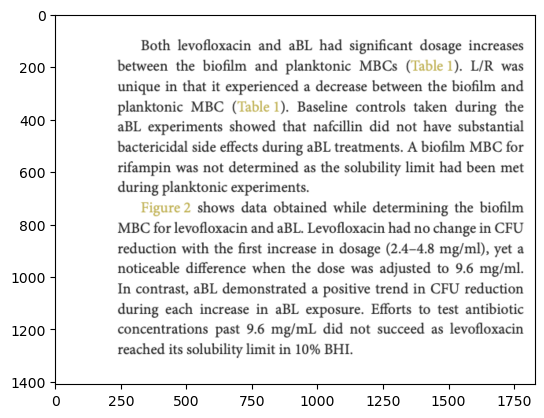

In [33]:
dimension = (1830,1410)
img3 = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
plt.imshow(img3)

In [35]:
query3_vectors = build_context_layout(img3)
len(query3_vectors)

total no of words(>3 chars) identified: 111
total no of contexts extracted: 111


111

In [36]:
feature_distance(query3_vectors,doc_vectors)

(array([3.8 , 1.62, 2.7 , 1.25, 0.99, 4.67, 2.91, 2.43, 2.4 , 3.38, 1.39,
        1.55, 1.89, 3.96, 5.67, 2.64, 1.13, 1.6 , 1.56, 2.16, 3.15, 1.05,
        1.64, 1.43, 1.21, 1.19, 1.38, 1.02, 0.88, 1.39, 1.22, 1.42, 1.37,
        4.37, 1.01, 3.15, 1.32, 2.3 , 1.44, 1.09, 1.29, 1.75, 2.22, 2.15,
        1.32, 1.27, 2.05, 1.73, 1.47, 1.6 , 2.51, 3.4 , 2.35, 1.85, 1.2 ,
        0.88, 1.32, 1.47, 1.33, 1.8 , 1.56, 2.76, 1.38, 2.91, 1.53, 2.4 ,
        1.73, 3.4 , 1.89, 3.92, 2.64, 2.96, 2.52, 2.38, 2.79, 1.68, 0.88,
        1.7 , 1.62, 1.03, 1.22, 1.64, 2.41, 1.83, 3.43, 2.45, 2.4 , 1.8 ,
        1.99, 2.3 , 2.63, 1.46, 1.6 , 0.4 , 0.64, 1.35, 2.16, 1.54, 3.03,
        2.49, 0.91, 1.37, 1.54, 1.18, 0.82, 3.25, 1.66, 1.85, 4.  , 2.93,
        3.66]),
 223.31)

In [37]:
feature_distance(query_vectors,query3_vectors)

(array([3.8 , 1.91, 2.09, 0.99, 0.96, 2.24, 2.91, 1.57, 2.16, 1.19, 4.15,
        1.75, 0.88, 1.34, 1.69, 3.15, 1.98, 1.9 , 1.73, 1.09, 1.8 , 1.7 ,
        1.39, 1.85, 1.65, 1.96, 1.3 , 1.05, 1.82, 2.88, 1.96, 1.25, 1.66,
        0.99, 1.65, 2.18, 2.17, 2.4 , 4.3 , 3.21, 1.34, 1.75, 2.25, 4.64,
        2.6 , 4.74, 3.13, 6.91, 2.85, 2.66, 1.03, 3.08, 4.33, 1.4 , 2.68,
        2.75, 2.29, 1.27, 1.13, 1.92, 2.57, 1.22, 2.5 , 2.24, 2.78, 1.62,
        2.22, 2.11, 1.89, 1.14, 1.29, 0.4 , 0.64, 2.18, 2.07, 2.62, 1.8 ,
        2.13, 2.48, 3.04, 0.82, 1.66, 1.84, 5.25, 5.91]),
 187.82)

In [38]:
feature_distance(query3_vectors,query2_vectors)

(array([2.44, 1.19, 0.82, 1.1 , 3.24, 1.01, 2.04, 1.9 , 1.38, 1.2 , 2.23,
        4.97, 3.5 , 1.  , 0.84, 1.26, 1.77, 2.42, 0.12, 0.16, 0.12, 0.16,
        0.15, 0.16, 0.13, 0.15, 0.17, 1.73, 0.17, 0.15, 0.26, 0.12, 0.26,
        0.16, 0.19, 0.16, 0.1 , 1.56, 1.82, 2.41, 0.1 , 0.1 , 0.13, 0.72,
        1.63, 2.63, 0.24, 4.41, 0.36, 0.11, 0.09, 0.12, 1.95, 2.12, 0.13,
        1.06, 0.64, 0.95, 0.14, 2.79, 1.06, 2.5 , 1.62, 3.23, 2.86, 3.96,
        2.11, 2.32, 2.43, 2.37, 1.47, 2.4 , 1.06, 1.51, 1.58, 1.53, 2.7 ,
        2.14, 2.67, 2.72, 0.09, 1.8 , 1.9 , 0.96, 2.03, 1.12, 1.49, 0.1 ,
        0.18, 0.16, 0.16, 0.16, 0.21, 0.24, 0.15, 0.11, 0.16, 0.15, 0.2 ,
        0.26, 0.17, 0.1 , 0.18, 0.25, 3.2 ]),
 124.91)